In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
filepath = '/content/timeseriesdata.csv'
df = pd.read_csv(filepath)
df

,Quarter,hdbrpi,labour-cost,gdp,population,cpi,exchange-rate,consumer-spending,overall unemployment,sti
0,1990 1Q,24.3,74.7,"16,669.50","2,647,627",61.907,1.8843,16.113111,31600,1458.400000
1,1990 2Q,24.4,70.5,"17,087.70","2,677,041",62.501,1.8396,16.999927,31600,1527.000000
2,1990 3Q,25.0,73.8,"17,930.10","2,706,454",63.181,1.7632,17.886744,31600,1098.700000
3,1990 4Q,24.7,84.9,"18,805","2,735,868",63.969,1.7445,18.773560,31600,1154.800000
4,1991 1Q,24.9,80.5,"18,521","2,750,577",64.249,1.7931,19.660376,31600,1490.800000
...,...,...,...,...,...,...,...,...,...,...
91,2012 4Q,146.7,98.3,"94,848.80","3,818,205",97.936,1.2221,113.643019,63500,3167.080078
92,2013 1Q,148.6,101.0,"93,773","3,824,842",98.574,1.2436,114.828898,65700,3308.100098
93,2013 2Q,149.4,88.5,"95,587.20","3,831,478",97.656,1.2652,115.705388,67900,3150.439941
94,2013 3Q,148.1,89.3,"96,028.30","3,838,115",98.865,1.2572,116.581878,63300,3167.870117


In [3]:
def todatetime(row):
    row['Quarter'] = row['Quarter'].replace(' 1Q', '-03')
    row['Quarter'] = row['Quarter'].replace(' 2Q', '-06')
    row['Quarter'] = row['Quarter'].replace(' 3Q', '-09')
    row['Quarter'] = row['Quarter'].replace(' 4Q', '-12')
    
    return row

df1 = df.apply(todatetime, axis='columns')
df1['Quarter'] = pd.to_datetime(df1['Quarter'], infer_datetime_format = True)

In [4]:
def tofloat(row):
    row['gdp'] = row['gdp'].replace(',', '')
    row['population'] = row['population'].replace(',', '')
    return row

df2 = df1.apply(tofloat, axis='columns')
df2['gdp'] = df2['gdp'].astype(float)
df2['population'] = df2['population'].astype(float)
df2['overall unemployment'] = df2['overall unemployment'].astype(float)

In [5]:
df3 = df2.drop(columns = 'Quarter')
df4 = df3.hdbrpi

In [6]:
data = df4.to_numpy()
data.shape

(96,)

In [7]:
num_features = 1
data = data.reshape((len(data), num_features))
data.shape

(96, 1)

In [8]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, data, test_size=0.2, random_state=0, shuffle=False)

In [21]:
win_length = 5
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)

(76, 1)
(76, 1)
(20, 1)


In [10]:
train_generator = TimeseriesGenerator(Xtrain, Ytrain, length=win_length, sampling_rate=1, batch_size=96)
test_generator = TimeseriesGenerator(Xtest, Ytest, length=win_length, sampling_rate=1, batch_size=96)

In [11]:
X_train = train_generator[0][0]
Y_train = train_generator[0][1]
X_test = test_generator[0][0]
Y_test = test_generator[0][1]
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(71, 5, 1)
(71, 1)
(15, 5, 1)
(15, 1)


In [12]:
X_train[0]

array([[24.3],
       [24.4],
       [25. ],
       [24.7],
       [24.9]])

In [13]:
X_train[0].flatten()

array([24.3, 24.4, 25. , 24.7, 24.9])

In [14]:
fX_train = []
for i in range(len(X_train)):
  fX_train.append(X_train[i].flatten())

In [15]:
fX_train = np.array(fX_train)

In [16]:
fX_test = []
for i in range(len(X_test)):
  fX_test.append(X_test[i].flatten())

In [17]:
fX_test = np.array(fX_test)

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(win_length,)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dense(6, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [19]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(fX_train, Y_train, epochs=200, validation_data=(fX_test, Y_test), batch_size=6)

Epoch 1/200
12/12 [==============================] - 1s 42ms/step - loss: 3943.2284 - mean_absolute_error: 53.4326 - val_loss: 2803.6382 - val_mean_absolute_error: 52.2528
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 794.7764 - mean_absolute_error: 24.8805 - val_loss: 274.8022 - val_mean_absolute_error: 16.4109
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 154.1284 - mean_absolute_error: 10.9142 - val_loss: 61.8240 - val_mean_absolute_error: 7.3656
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 44.0377 - mean_absolute_error: 4.8813 - val_loss: 26.6076 - val_mean_absolute_error: 3.8657
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 49.5984 - mean_absolute_error: 5.5026 - val_loss: 51.4065 - val_mean_absolute_error: 6.7037
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 29.9556 - mean_absolute_error: 4.1929 - val_loss: 15.9588 - val_mean_absolute_error: 2.90

In [20]:
print("train MSE", history.history['loss'][-1])
print("val MSE", history.history['val_loss'][-1])

train MSE 8.714820861816406
val MSE 3.2931129932403564


In [29]:
plot_generator = TimeseriesGenerator(data, data, length=win_length, sampling_rate=1, batch_size=96)
Xplot = plot_generator[0][0]
Yplot = plot_generator[0][1]

In [30]:
fX_plot = []
for i in range(len(Xplot)):
  fX_plot.append(Xplot[i].flatten())

fX_plot = np.array(fX_plot)

In [31]:
Y_pred = model.predict(fX_plot)
Y_pred.shape

(91, 1)

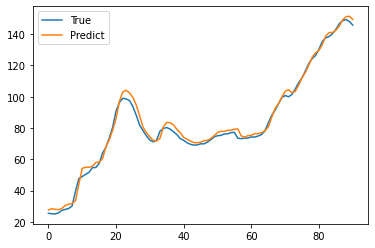

In [32]:
plt.plot(Yplot, label='True')
plt.plot(Y_pred,  label='Predict')
plt.legend()
plt.show()